In [12]:
import numpy as np
from scipy.special import legendre, chebyt, jv, hermite, eval_laguerre

def make_function(x, kind="random", max_freq=10):
    """
    Generate a diverse set of functions for Fourier testing.

    Parameters:
        x        : array of input points
        kind     : type of function to generate; if 'random', one is picked randomly
        max_freq : maximum frequency for Fourier-type functions

    Returns:
        f        : array of function values
    """
    
    if kind == "random":
        kind = np.random.choice([
            "fourier", "poly", "gaussian", "gaussian_mixture",
            "damped_sine", "exp_decay", "piecewise", "trig_combo",
            "legendre", "chebyshev", "bessel",
            "hermite", "laguerre",
            "windowed_sine", "rect_pulse", "sawtooth", "triangle",
            "modulated", "chirp", "spikes", "wavelet"
        ])
    
    # ----------------- Standard types -----------------
    if kind == "fourier":
        coeffs = np.random.randn(max_freq)
        f = np.zeros_like(x, dtype=float)
        for n, a in enumerate(coeffs, start=1):
            f += a * np.sin(np.pi * n * x)
        return f

    elif kind == "poly":
        coeffs = np.random.randn(5)
        return sum(c * x**i for i, c in enumerate(coeffs))

    elif kind == "gaussian":
        mu, sigma = np.random.uniform(-0.5, 0.5), np.random.uniform(0.05, 0.5)
        return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

    elif kind == "gaussian_mixture":
        num_gaussians = np.random.randint(2, 4)
        f = np.zeros_like(x)
        for _ in range(num_gaussians):
            mu, sigma, amp = np.random.uniform(-0.5,0.5), np.random.uniform(0.05,0.3), np.random.uniform(0.5,2.0)
            f += amp * np.exp(-((x - mu)**2) / (2 * sigma**2))
        return f

    elif kind == "damped_sine":
        freq = np.random.uniform(1, max_freq)
        decay = np.random.uniform(0.5, 2.0)
        phase = np.random.uniform(0, 2*np.pi)
        return np.exp(-decay * np.abs(x)) * np.sin(2 * np.pi * freq * x + phase)

    elif kind == "exp_decay":
        lam = np.random.uniform(0.5, 2.0)
        return np.exp(-lam * np.abs(x))

    elif kind == "piecewise":
        split = np.random.uniform(x[0], x[-1])
        return np.piecewise(x, [x < split, x >= split],
                            [lambda t: t**2, lambda t: -t + split])

    elif kind == "trig_combo":
        f = np.zeros_like(x)
        num_terms = np.random.randint(2, 5)
        for _ in range(num_terms):
            amp = np.random.uniform(0.5, 2.0)
            freq = np.random.randint(1, max_freq)
            phase = np.random.uniform(0, 2*np.pi)
            f += amp * (np.sin(2*np.pi*freq*x + phase) + np.cos(2*np.pi*freq*x + phase))
        return f

    # ----------------- Special polynomials -----------------
    elif kind == "legendre":
        deg = np.random.randint(1, 6)
        P = legendre(deg)
        return P(x)

    elif kind == "chebyshev":
        deg = np.random.randint(1, 6)
        T = chebyt(deg)
        return T(x)

    elif kind == "bessel":
        order = np.random.randint(0, 6)
        k = np.random.uniform(1, 10)
        return jv(order, k * x)

    elif kind == "hermite":
        deg = np.random.randint(1,5)
        H = hermite(deg)
        return H(x)

    elif kind == "laguerre":
        deg = np.random.randint(1,5)
        return eval_laguerre(deg, np.abs(x))  # Laguerre defined on [0,∞)

    # ----------------- Windowed / localized functions -----------------
    elif kind == "windowed_sine":
        freq = np.random.uniform(1, max_freq)
        alpha = np.random.uniform(1,5)
        return np.sin(2*np.pi*freq*x) * np.exp(-alpha*x**2)

    elif kind == "rect_pulse":
        start, end = np.random.uniform(-0.5, 0), np.random.uniform(0,0.5)
        return np.where((x>=start) & (x<=end), 1.0, 0.0)

    elif kind == "sawtooth":
        return 2*(x - np.floor(x + 0.5))  # normalized sawtooth

    elif kind == "triangle":
        return 2*np.abs(2*(x - np.floor(x + 0.5))) - 1

    elif kind == "modulated":
        f1 = np.sin(5*np.pi*x)
        f2 = np.cos(2*np.pi*x)
        return f1*f2

    elif kind == "chirp":
        return np.sin(2*np.pi*(x + x**2))

    elif kind == "spikes":
        f = np.zeros_like(x)
        num_spikes = np.random.randint(3,8)
        indices = np.random.choice(len(x), num_spikes, replace=False)
        f[indices] = np.random.uniform(1,3, size=num_spikes)
        return f

    elif kind == "wavelet":
        return (1 - x**2) * np.exp(-x**2 / 2)  # Mexican hat

    else:
        raise ValueError(f"Unknown function type '{kind}'")

# List of all available function types
function_types = [
    "fourier",          # sum of sinusoids
    "poly",             # standard polynomial
    "gaussian",         # single Gaussian
    "gaussian_mixture", # sum of Gaussians
    "damped_sine",      # exponentially damped sinusoid
    "exp_decay",        # exponential decay
    "piecewise",        # piecewise linear/quadratic
    "trig_combo",       # combination of sin and cos
    "legendre",         # Legendre polynomials
    "chebyshev",        # Chebyshev polynomials (1st kind)
    "bessel",           # Bessel function of first kind
    "hermite",          # Hermite polynomials
    "laguerre",         # Laguerre polynomials
    "windowed_sine",    # sinusoid multiplied by Gaussian
    "rect_pulse",       # rectangular pulse
    "sawtooth",         # sawtooth wave
    "triangle",         # triangle wave
    "modulated",        # product of sinusoids (beats)
    "chirp",            # frequency-increasing sinusoid
    "spikes",           # sparse impulses
    "wavelet"           # Mexican hat wavelet
]


def generate_dataset(num_samples, N, domain):
    x = np.linspace(domain[0], domain[1], N, endpoint=False)
    dx = x[1] - x[0]
    # freqs = np.fft.fftfreq(N, d=dx)

    data_f = []
    data_F = []

    for _ in range(num_samples):
        kind = np.random.choice(function_types)
        f = make_function(x, kind=kind)
        F = np.fft.fft(f) * dx
        F = np.fft.fftshift(F)
        # freqs_shifted = np.fft.fftshift(freqs)

        data_f.append(f.astype(np.float32))
        data_F.append(np.stack([F.real, F.imag], axis=-1).astype(np.float32))
    
    return np.array(data_f), np.array(data_F)

Saved to disc_256.csv


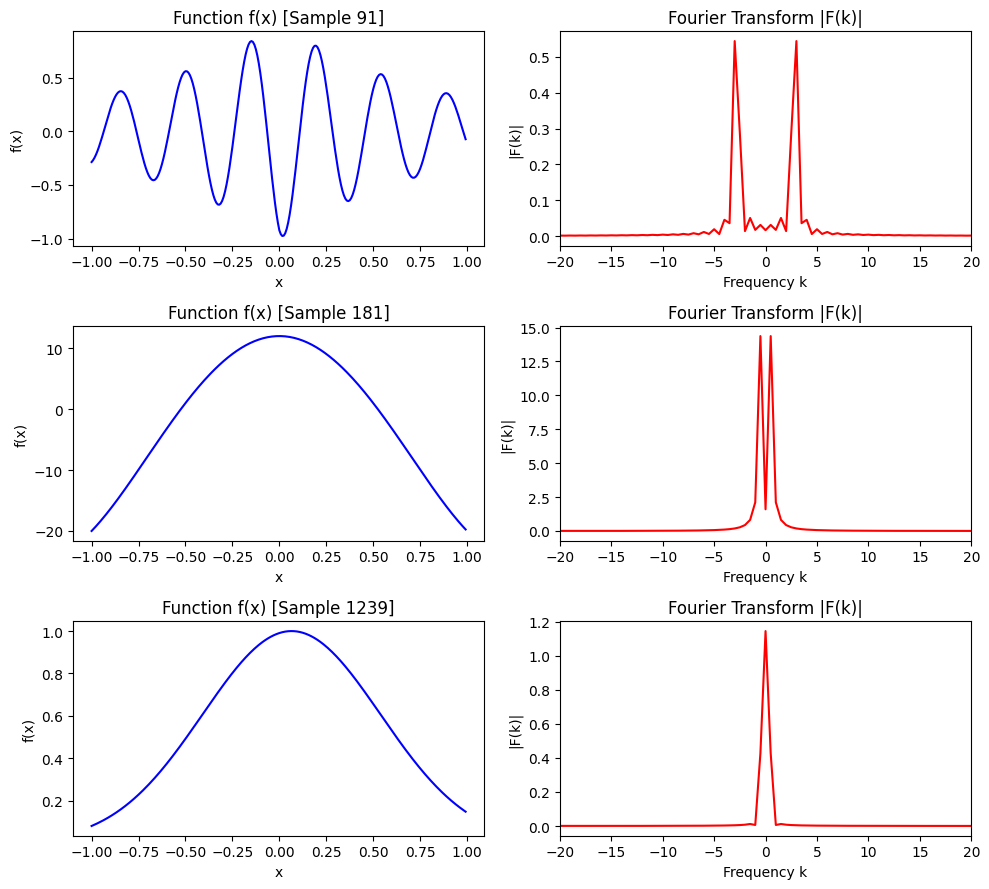

In [15]:
import matplotlib.pyplot as plt
num_samples = 2500 #fixed
def save_data(filename, N, domain):
    f_data, F_data = generate_dataset(num_samples, N, domain)
    # Flatten all samples along rows
    f_flat = f_data.reshape(-1)            # shape (num_samples*N,)
    Re_flat = F_data[:,:,0].reshape(-1)    # shape (num_samples*N,)
    Im_flat = F_data[:,:,1].reshape(-1)    # shape (num_samples*N,)
    
    table = np.column_stack([f_flat, Re_flat, Im_flat])
    
    # Save with header
    header = f"N={N}, domain=({domain[0]}, {domain[1]})\n" \
             "f(x),Re,Im"
    
    np.savetxt(filename, table, delimiter=",", fmt="%.9f",
               header=header, comments = "")
    print(f"Saved to {filename}")

    # --- Plot some random samples ---
    x_grid = np.linspace(domain[0], domain[1], N, endpoint = False)
    k_grid = np.fft.fftfreq(N, d = x_grid[1] - x_grid[0])
    k_grid = np.fft.fftshift(k_grid)
    num_plots = 3
    indices = np.random.choice(len(f_data), num_plots, replace=False)
    
    fig, axes = plt.subplots(num_plots, 2, figsize=(10, 3*num_plots))
    k_zoom = 20
    
    for i, idx in enumerate(indices):
        f = f_data[idx]
        F = F_data[idx]
        F_mag = np.sqrt(F[:,0]**2 + F[:,1]**2)  # magnitude
    
        axes[i,0].plot(x_grid, f, color='b')
        axes[i,0].set_title(f"Function f(x) [Sample {idx}]")
        axes[i,0].set_xlabel("x")
        axes[i,0].set_ylabel("f(x)")
    
        axes[i,1].plot(k_grid, F_mag, color='r')
        axes[i,1].set_title("Fourier Transform |F(k)|")
        axes[i,1].set_xlabel("Frequency k")
        axes[i,1].set_ylabel("|F(k)|")
        axes[i, 1].set_xlim(-k_zoom, k_zoom)
    
    plt.tight_layout()
    plt.show()

save_data("disc_256.csv", 256, (-1, 1))